## GAN试炼场

进入修罗场了哦！

In [1]:
import numpy as np
import time
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import torchvision
from scipy.stats import rv_discrete
%matplotlib inline
import os
from os.path import join, dirname, exists
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
import collections
from torch import autograd
from IPython import display

NOISE_DIM = 20
torch.set_num_threads(4)
np.random.seed(12345)
lims = (-5, 5)

In [2]:
def sample_true(N, ind):
    if ind == 1:
        MEANS = np.array([[0.3, 0.2], [1, 1.2]])
        COVS = np.array([[[0.7, 0.3], [0.3, 0.2]],
                         [[0.7, -0.3], [-0.3, 0.2]]])
        PROBS = np.array([0.5, 0.5])
        assert len(MEANS) == len(COVS) == len(
            PROBS), "number of components mismatch"
        COMPONENTS = len(MEANS)

        comps_dist = rv_discrete(values=(range(COMPONENTS), PROBS))
        comps = comps_dist.rvs(size=N)
        conds = np.arange(COMPONENTS)[:, None] == comps[None, :]
        arr = np.array([np.random.multivariate_normal(MEANS[c], COVS[c], size=N)
                        for c in range(COMPONENTS)])
        return np.select(conds[:, :, None], arr).astype(np.float32)
    
    if ind == 2:
        rand = np.random.RandomState(0)
        def get_samples(c, size):
            if c==0:
                return np.random.multivariate_normal([-1.5, 2.5], [[0.2, 0], [0, 0.2]], size=N)
            if c==1:
                return np.random.multivariate_normal([1.5, 2.5], [[0.2, 0], [0, 0.2]], size=N)
            if c==2:
                noise = rand.rand(N)
                samples = np.c_[2 * np.cos(np.pi * noise), -2 * np.sin(np.pi * noise)]
                samples += rand.randn(*samples.shape) * 0.2
                return samples
        PROBS = np.array([1/3, 1/3, 1/3])
        COMPONENTS = 3
        comps_dist = rv_discrete(values=(range(COMPONENTS), PROBS))
        comps = comps_dist.rvs(size=N)
        conds = np.arange(COMPONENTS)[:, None] == comps[None, :]
        arr = np.array([get_samples(c, N) for c in range(COMPONENTS)])
        return np.select(conds[:, :, None], arr).astype(np.float32)

def sample_noise(N):
    return np.random.normal(size=(N, NOISE_DIM)).astype(np.float32)

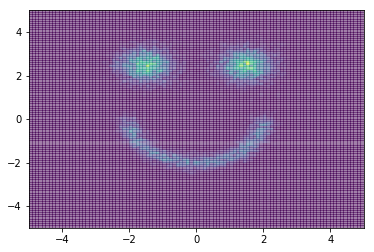

In [5]:
data = sample_true(10000, ind=2)
vis_data(data)

In [4]:
fixed_noise = torch.Tensor(sample_noise(5000))

def vis_data(data):
    hist = np.histogram2d(data[:, 1], data[:, 0], bins=100, range=[lims, lims])
    plt.pcolormesh(hist[1], hist[2], hist[0], alpha=0.5)

    
def vis_g(generator):
    samples = generator(fixed_noise).data.numpy()
    if np.isnan(data).any():
        return
    plt.hist2d(samples[:, 0], samples[:, 1], bins=100, alpha=0.7, cmap=plt.cm.viridis_r, range=[lims, lims])

def vis_points(data):
    if np.isnan(data).any():
        return
    
    plt.scatter(data[:,0], data[:,1], alpha=0.2, c='b')
    plt.xlim(lims)
    plt.ylim(lims)
    

def get_grid():
    X, Y = np.meshgrid(np.linspace(lims[0], lims[1], 40), np.linspace(lims[0], lims[1], 40))
    X = X.flatten()
    Y = Y.flatten()
        
    grid = torch.from_numpy(np.vstack([X, Y]).astype(np.float32).T)
    grid.requires_grad = True
                            
    return X, Y, grid
              
def vis_d(generator, critic, g_loss_fn, TASK):
    """
        Visualizes discriminator's gradient on grid
    """
    X_grid, Y_grid, grid = get_grid()   
    data_gen = generator(fixed_noise)
    #     loss = d_loss(discriminator(data_gen), discriminator(grid))
    loss = g_loss_fn(critic(grid), TASK)
    loss.backward()
    
    grads = - grid.grad.data.numpy()
    grid.grad.data *= 0 
    plt.quiver(X_grid, Y_grid, grads[:, 0]/2, grads[:, 1]/2, color='black',alpha=0.9)

In [6]:
def get_generator(noise_dim, out_dim, hidden_dim=128):
    layers = [
        nn.Linear(noise_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, out_dim)
    ]
    return nn.Sequential(*layers)

def get_discriminator(in_dim, hidden_dim=128):
    layers = [
        nn.Linear(in_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, 1),
        nn.Sigmoid()
    ]
    return nn.Sequential(*layers)

def get_critic(in_dim, hidden_dim=128):
    layers = [
        nn.Linear(in_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, 1)
    ]
    return nn.Sequential(*layers)

def get_sn_critic(in_dim, hidden_dim=128):
    layers = [
        nn.utils.spectral_norm(nn.Linear(in_dim, hidden_dim)),
        nn.LeakyReLU(),
        nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)),
        nn.LeakyReLU(),
        nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)),
        nn.LeakyReLU(),
        nn.utils.spectral_norm(nn.Linear(hidden_dim, 1))
    ]
    return nn.Sequential(*layers)

def g_loss_fn(d_scores_fake, TASK):
    """
        `d_scores_fake` is the output of the discrimonator model applied to a batch of fake data
        
        NOTE: we always define objectives as if we were minimizing them (remember that maximize = negate and minimize)
    """
    if TASK == 1: 
        return torch.log(1 - d_scores_fake).mean()
    elif TASK == 2:
        return -torch.log(d_scores_fake).mean()
    elif TASK == 3 or TASK == 4 or TASK == 5:
        return -d_scores_fake.mean()
    else:
        return -d_scores_fake.mean()
    
def c_loss_fn(d_scores_fake, d_scores_real, TASK):
    """
        `d_scores_fake` is the output of the discriminator model applied to a batch of fake data
        `d_scores_real` is the output of the discriminator model applied to a batch of real data
        
        NOTE: we always define objectives as if we were minimizing them (remember that maximize = negate and minimize)
    """
    if TASK == 1: 
        return -torch.log(d_scores_real).mean() - torch.log(1 - d_scores_fake).mean()
    elif TASK == 2:
        return -torch.log(d_scores_real).mean() - torch.log(1 - d_scores_fake).mean()
    elif TASK == 3 or TASK == 4 or TASK == 5:
        return d_scores_fake.mean() - d_scores_real.mean()
    else:
        return -torch.clamp(d_scores_real-1, max=0).mean() - torch.clamp(-d_scores_fake-1, max=0).mean()

In [24]:
def gradient_penalty(critic, real_data, fake_data):
    alpha = torch.rand(real_data.shape[0], 1)
    alpha = alpha.expand(real_data.size())

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = critic(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10

    return gradient_penalty


def wgan_train(visual, TASK, epoch, generator, critic, g_loss_fn, c_loss_fn, train_loader, g_optimizer, c_optimizer,
               n_critic=1, g_scheduler=None, c_scheduler=None):

    g_losses, c_losses = [], []
    generator.train()
    critic.train()
    for i, real_data in enumerate(tqdm_notebook(train_loader, desc='Batch', leave=False)):
        real_data = real_data.float()
        c_optimizer.zero_grad()
        noise = torch.Tensor(sample_noise(real_data.shape[0]))
        fake_data = generator(noise)
        scores_real = critic(fake_data)
        c_loss = c_loss_fn(scores_real, critic(real_data), TASK)
        c_loss.backward()

        if TASK == 4:
            gp_loss = gradient_penalty(critic, real_data, fake_data)
            gp_loss.backward()

        c_optimizer.step()
        if TASK == 4:
            c_losses.append(c_loss.item() + gp_loss.item())
        else:
            c_losses.append(c_loss.item())

        if TASK == 3:
            for p in critic.parameters():
                p.data.clamp_(-0.01, 0.01)

        if i % n_critic == 0:
            g_optimizer.zero_grad()
            noise = torch.Tensor(sample_noise(real_data.shape[0]))
            fake_data = generator(noise)
            g_loss = g_loss_fn(critic(fake_data), TASK)
            g_loss.backward()
            g_optimizer.step()
            g_losses.append(g_loss.item())
            if g_scheduler is not None:
                g_scheduler.step()
            if c_scheduler is not None:
                c_scheduler.step()

        if i % 32 == 0:
            plt.clf()
            vis_data(visual)
            vis_g(generator)
            vis_d(generator, critic, g_loss_fn, TASK)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print(f"Task {TASK}; Iteration {i}; Epoch {epoch}")
            
    return dict(g_losses=g_losses, c_losses=c_losses)


def wgan_train_epochs(visual, TASK, generator, critic, g_loss_fn, c_loss_fn, train_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    if 'optim_cls' in train_args:
        g_optimizer = train_args['optim_cls'](generator.parameters(), lr=lr)
        c_optimizer = train_args['optim_cls'](critic.parameters(), lr=lr)
    else:
        g_optimizer = optim.Adam(
            generator.parameters(), lr=lr, betas=(0, 0.9))
        c_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))

    if train_args.get('lr_schedule', None) is not None:
        g_scheduler = optim.lr_scheduler.LambdaLR(
            g_optimizer, train_args['lr_schedule'])
        c_scheduler = optim.lr_scheduler.LambdaLR(
            c_optimizer, train_args['lr_schedule'])
    else:
        g_scheduler = None
        c_scheduler = None
    
    train_losses = dict()
    try:
        for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):

            generator.train()
            critic.train()
            train_loss = wgan_train(visual, TASK, epoch, generator, critic, g_loss_fn, c_loss_fn, train_loader, g_optimizer,
                                    c_optimizer, n_critic=train_args.get(
                                        'n_critic', 0),
                                    g_scheduler=g_scheduler, c_scheduler=c_scheduler)

            for k in train_loss.keys():
                if k not in train_losses:
                    train_losses[k] = []
                train_losses[k].extend(train_loss[k])
    except KeyboardInterrupt:
        pass
    samples = generator(fixed_noise).data.numpy()
    return train_losses, samples

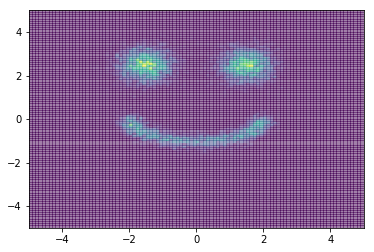

In [113]:
hist = np.histogram2d(data[:, 1], data[:, 0], bins=100, range=[lims, lims])
plt.pcolormesh(hist[1], hist[2], hist[0], alpha=0.5)
plt.savefig('smile_plot.png')

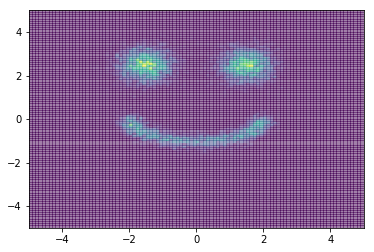

In [112]:
data = sample_true(10000, ind=2)
vis_data(data)

In [37]:
def wgan_fn(train_data, TASK, n_epochs, visual):
    N_EPOCHS = n_epochs
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = torch.utils.data.DataLoader(train_data, **loader_args)
    g = get_generator(NOISE_DIM, out_dim = 2)
    if TASK==3 or TASK==4:
        c = get_critic(in_dim = 2)
    elif TASK==1 or TASK==2:
        c = get_discriminator(in_dim = 2)
    else:
        c = get_sn_critic(in_dim=2) 
    if TASK==1 or TASK==2:
        N_CRITIC = 1
    else:
        N_CRITIC = 2
    train_args = dict(epochs=N_EPOCHS, lr=0.0001, n_critic=N_CRITIC)
    train_losses, samples = wgan_train_epochs(visual, TASK, g, c, g_loss_fn, c_loss_fn, train_loader, train_args)

    return train_losses, samples

In [10]:
def plot_gan_training(losses, title, fname):
    plt.figure()
    c_losses = losses['c_losses']
    g_losses = losses['g_losses']
    n_itr = len(g_losses)
    x_g = np.arange(n_itr)
    x_c = np.linspace(0, n_itr, len(c_losses))
    plt.plot(x_c, c_losses, label='c_loss')
    plt.plot(x_g, g_losses, label='g_loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    plt.savefig(fname)
    plt.show()

def gan_plot(data, samples, title, fname):
    plt.subplot(121)
    plt.hist2d(samples[:, 0], samples[:, 1], bins=(300, 300), alpha=0.7, label="fitted", range=[lims, lims])
    plt.colorbar()
    plt.title(f'Fitted {title}')
    plt.subplot(122)
    plt.hist2d(data[:, 0], data[:, 1], bins=(300, 300), alpha=0.7, label="data", range=[lims,lims])
    plt.colorbar()
    plt.title(f'Data {title}')
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()
    
def gan_results(fn, count, TASK, n_epochs, ind):
    data = sample_true(count, ind)
    visual = sample_true(10000, ind)
    losses, samples = fn(data, TASK, n_epochs, visual)
    
    # loss plot
    if TASK == 1:
        losses_title = 'GAN Losses'
        samples_title = "GAN"
    elif TASK == 2:
        losses_title = 'GAN-Non-Saturated Losses'
        samples_title = "GAN-Non-Saturated"
    elif TASK == 3:
        losses_title = 'WGAN-Weight-Clipping Losses'
        samples_title = "WGAN-Weight-Clipping"
    elif TASK == 4:
        losses_title = 'WGAN-GP Losses'
        samples_title = "WGAN-GP"
    elif TASK == 5:
        losses_title = 'WGAN-SN Losses'
        samples_title = "WGAN-SN"
    else:
        losses_title = 'GeoGAN-SN Losses'
        samples_title = "GeoGAN-SN"
    fname_loss = losses_title+f'_{ind}'
    fname_samples = samples_title+f'_{ind}'
    plot_gan_training(losses, losses_title, fname_loss)
    gan_plot(data, samples, samples_title, fname_samples)

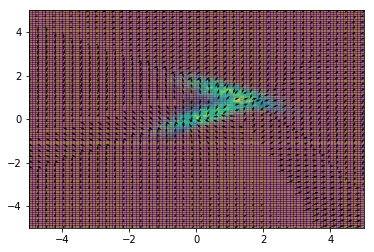

Task 4; Iteration 0; Epoch 399


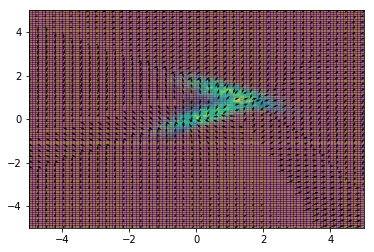

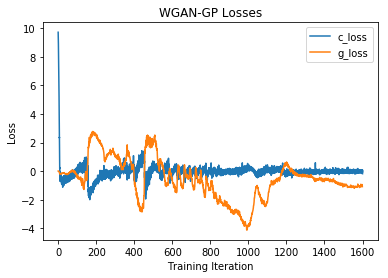

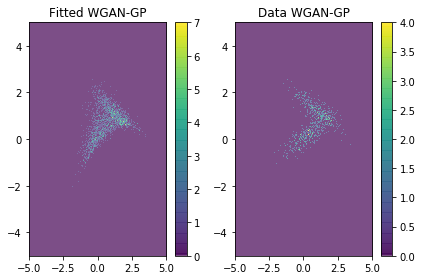

In [34]:
gan_results(wgan_fn, 2000, TASK = 4, n_epochs=400, ind=1)

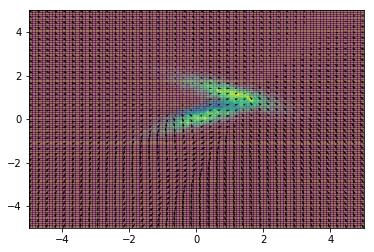

Task 4; Iteration 0; Epoch 399


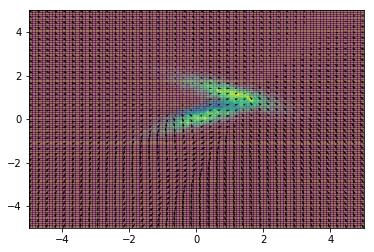

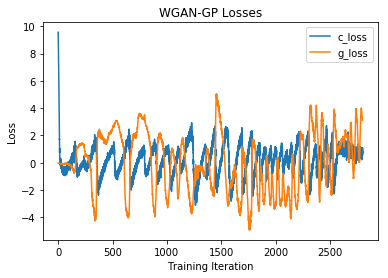

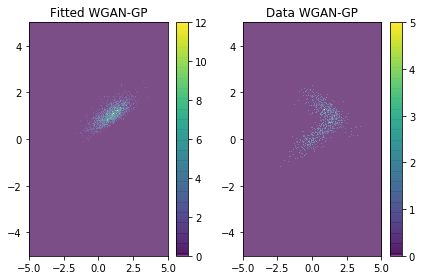

In [36]:
gan_results(wgan_fn, 2000, TASK = 4, n_epochs=400, ind=1)

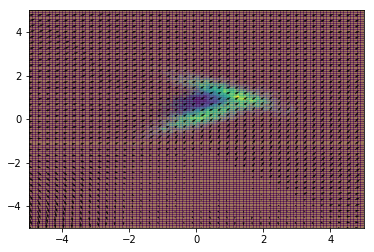

Task 4; Iteration 0; Epoch 399


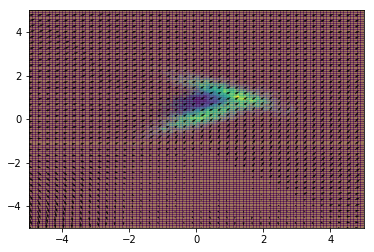

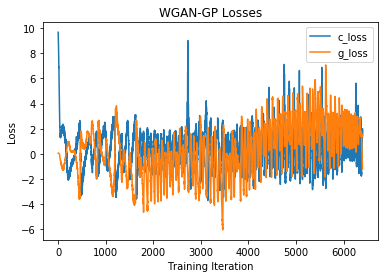

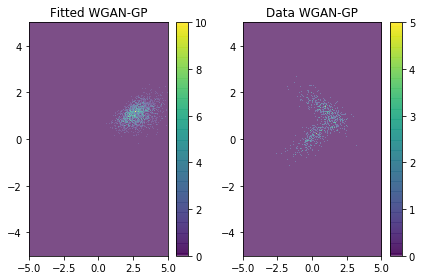

In [38]:
gan_results(wgan_fn, 2000, TASK = 4, n_epochs=400, ind=1)

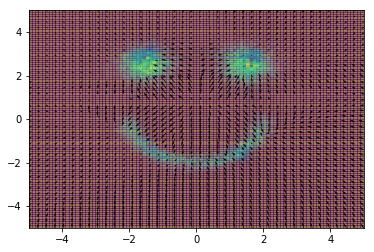

Task 0; Iteration 0; Epoch 199


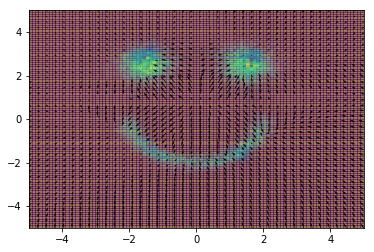

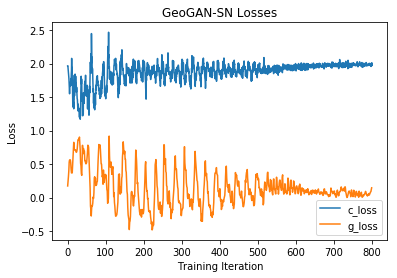

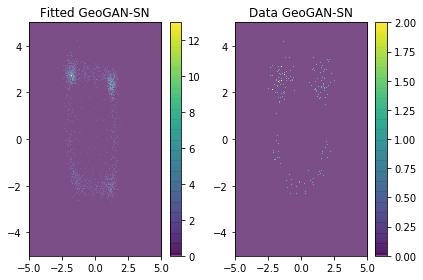

In [194]:
gan_results(wgan_fn, 500, TASK = 0, n_epochs=200, ind=2)

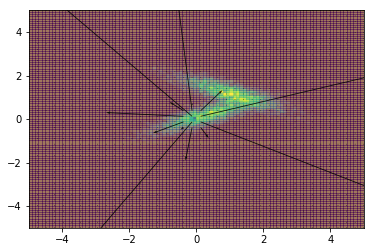

Task 2; Iteration 128; Epoch 0


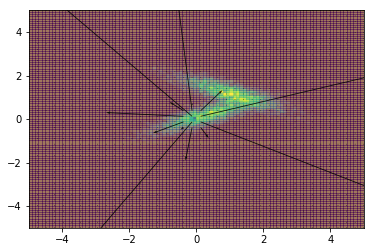

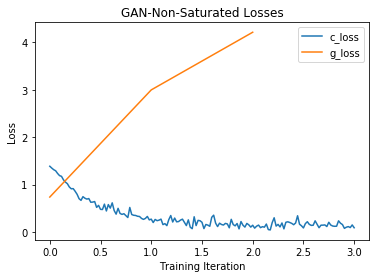

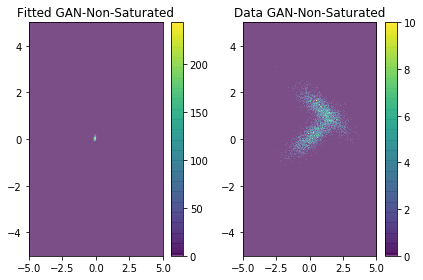

In [177]:
gan_results(wgan_fn, 10000, TASK = 2, n_epochs=1, ind=1)

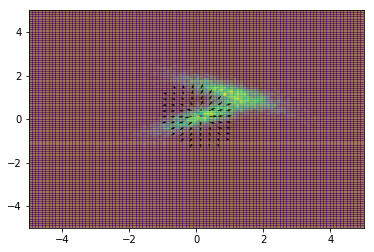

Task 1; Iteration 128; Epoch 0


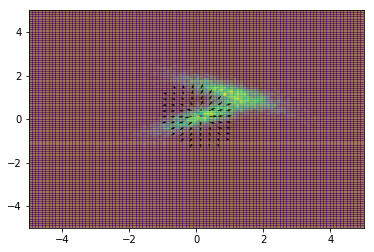

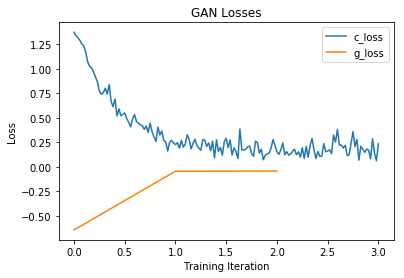

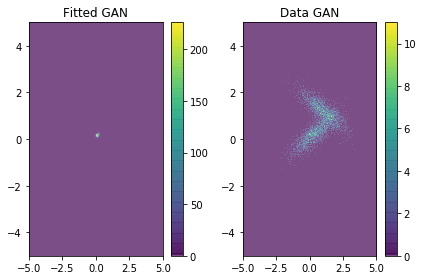

In [176]:
gan_results(wgan_fn, 10000, TASK = 1, n_epochs=1, ind=1)

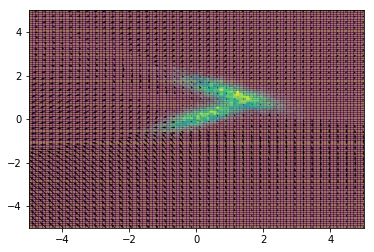

Task 1; Iteration 0; Epoch 99


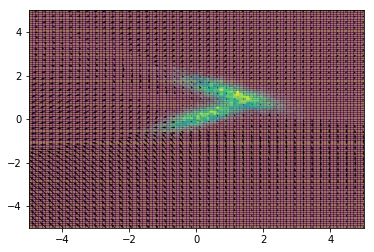

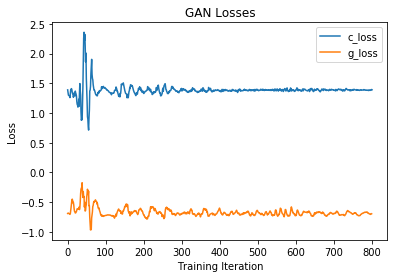

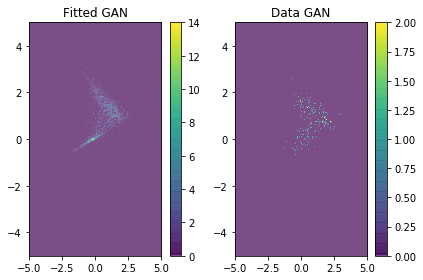

In [179]:
gan_results(wgan_fn, 500, TASK = 1, n_epochs=100, ind=1)

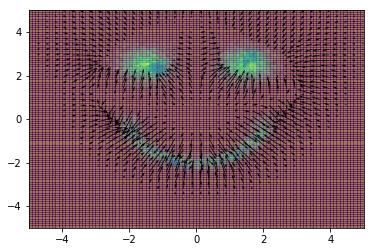

Task 1; Iteration 0; Epoch 199


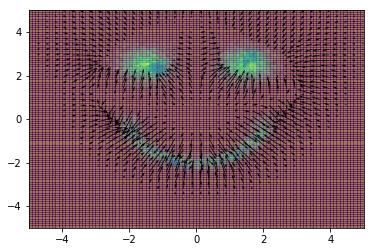

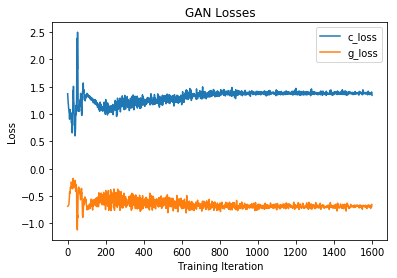

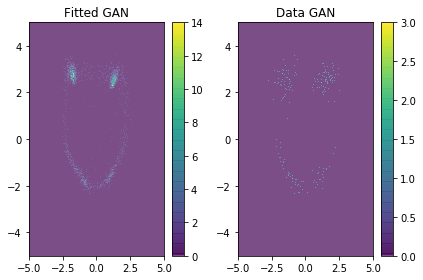

In [180]:
gan_results(wgan_fn, 500, TASK = 1, n_epochs=200, ind=2)

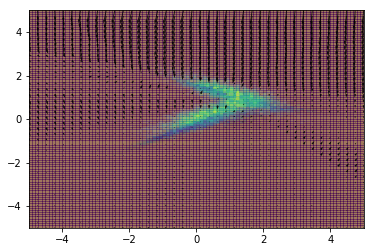

Task 2; Iteration 0; Epoch 99


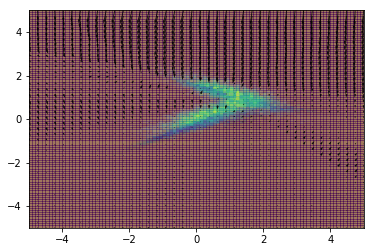

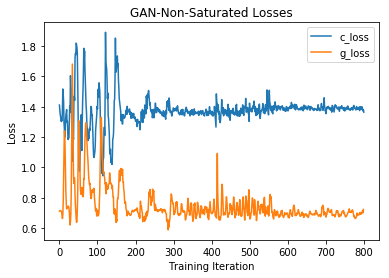

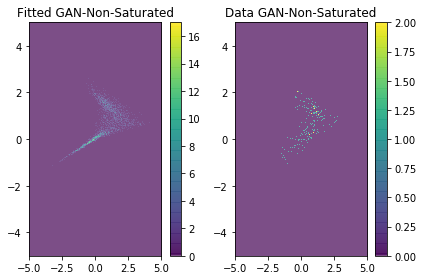

In [184]:
gan_results(wgan_fn, 500, TASK = 2, n_epochs=100, ind=1)

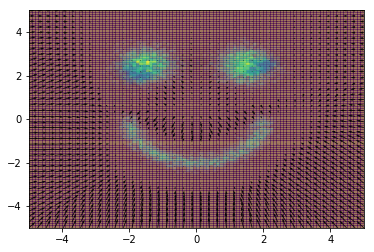

Task 2; Iteration 0; Epoch 99


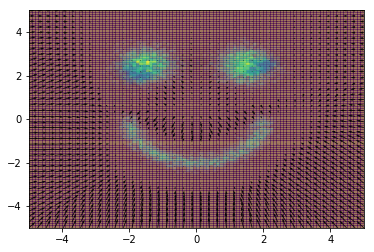

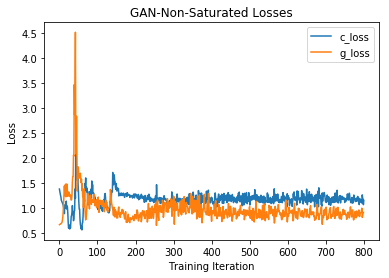

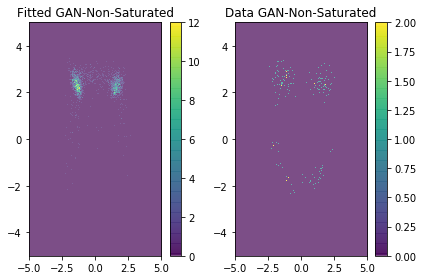

In [185]:
gan_results(wgan_fn, 500, TASK = 2, n_epochs=100, ind=2)

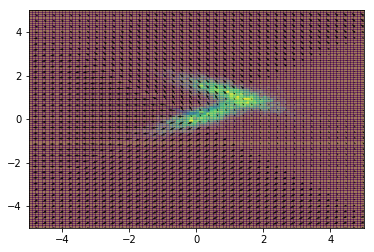

Task 3; Iteration 0; Epoch 99


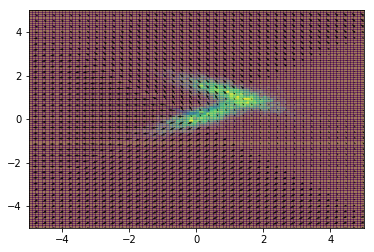

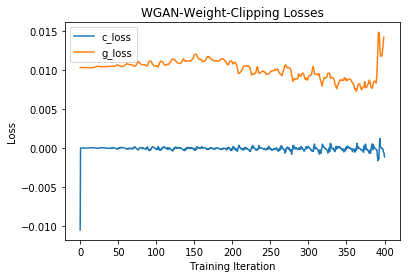

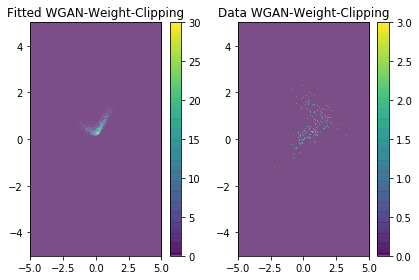

In [186]:
gan_results(wgan_fn, 500, TASK = 3, n_epochs=100, ind=1)

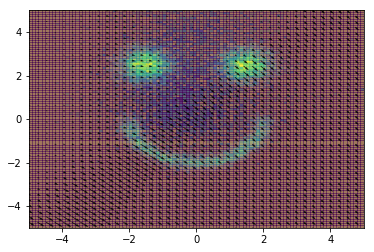

Task 3; Iteration 0; Epoch 99


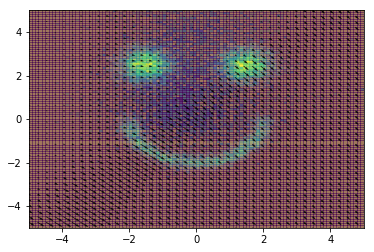

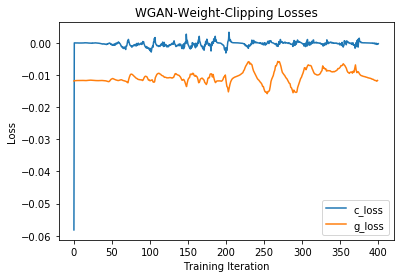

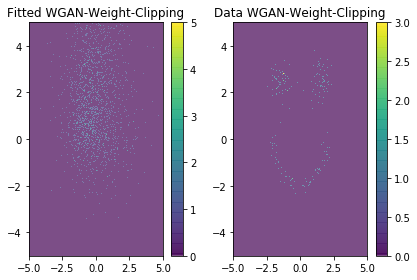

In [187]:
gan_results(wgan_fn, 500, TASK = 3, n_epochs=100, ind=2)

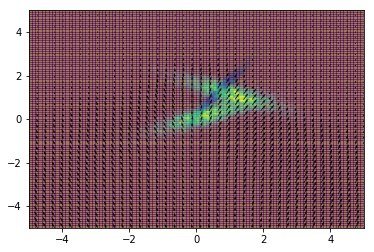

Task 4; Iteration 0; Epoch 199


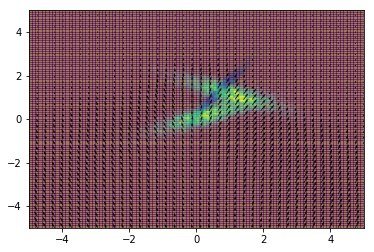

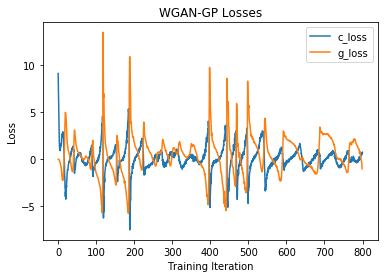

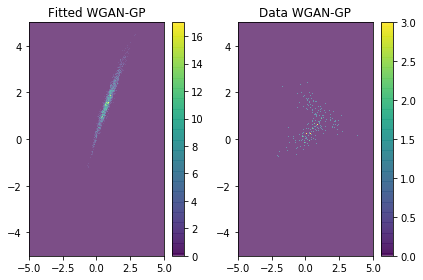

In [188]:
gan_results(wgan_fn, 500, TASK = 4, n_epochs=200, ind=1)

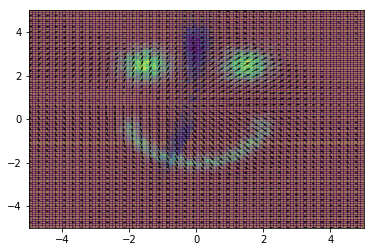

Task 4; Iteration 0; Epoch 299


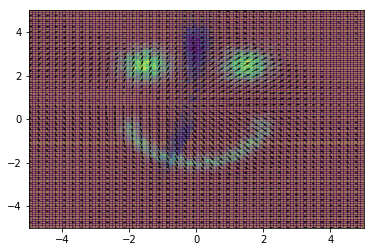

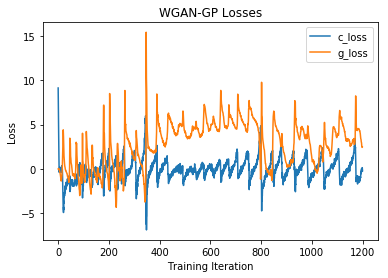

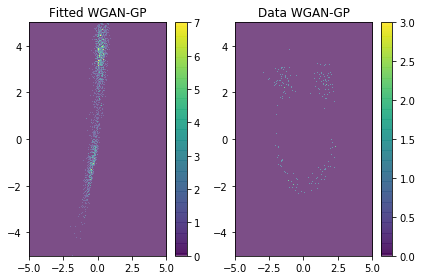

In [190]:
gan_results(wgan_fn, 500, TASK = 4, n_epochs=300, ind=2)

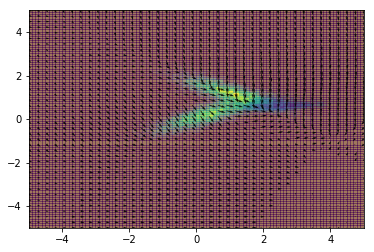

Task 5; Iteration 0; Epoch 299


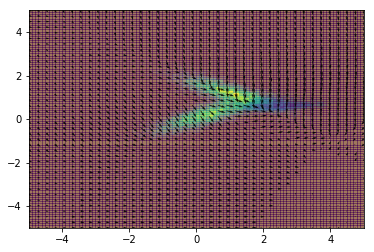

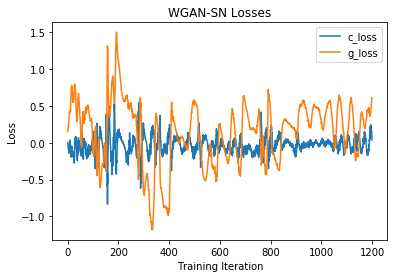

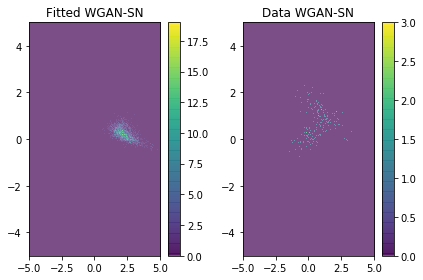

In [191]:
gan_results(wgan_fn, 500, TASK = 5, n_epochs=300, ind=1)

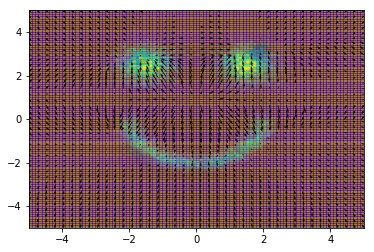

Task 5; Iteration 0; Epoch 299


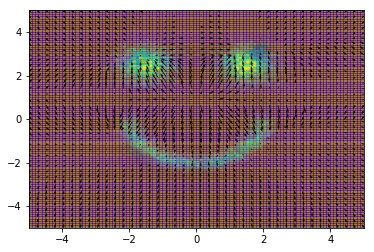

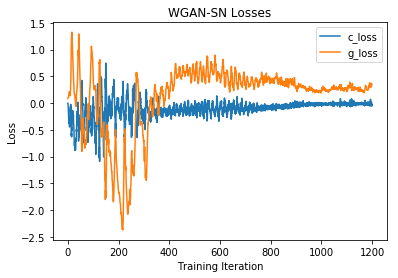

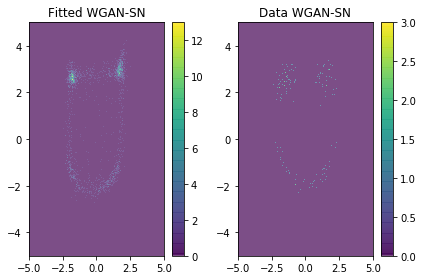

In [192]:
gan_results(wgan_fn, 500, TASK = 5, n_epochs=300, ind=2)